In [9]:
from torchvision import models
from models.resnet_ori import ResnetOri
import torch
import numpy as np
import torch.nn.functional as F


In [10]:
import sys
sys.path.append('..')

In [11]:
check_point_path = '../checkpoints/ckp_resnet_ori/fold_1_model_best.pth.tar'
model = ResnetOri(num_classes=6)
checkpoint = torch.load(check_point_path)
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [12]:
import pickle
pickle_path = '../data/ck+_6_classes_img_and_55_landmark.pickle'
if not os.path.exists(pickle_path):
    print('file {0} not exists'.format(pickle_path))
with open(pickle_path, 'rb') as f:
    print(f.name)
    data = pickle.load(f)

../data/ck+_6_classes_img_and_55_landmark.pickle


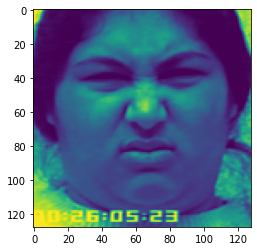

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(data[0]['img'][0])
plt.show()

In [14]:
model.eval()
net = model.resnet
# print(model)
features_blobs = []
finalconv_name = 'layer4'
def hook_feature(module, input, output): # input是注册层的输入 output是注册层的输出
    print("hook input",input[0].shape)
    features_blobs.append(output.data.cpu().numpy())
net._modules.get(finalconv_name).register_forward_hook(hook_feature)

params = list(net.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

In [15]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (128, 128)
    bz, nc, h, w = feature_conv.shape # 获取feature_conv特征的尺寸
    output_cam = []
    #lass_idx为预测分值较大的类别的数字表示的数组，一张图片中有N类物体则数组中N个元素
    for idx in class_idx:
    # weight_softmax中预测为第idx类的参数w乘以feature_map(为了相乘，故reshape了map的形状)

        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w))) # 把原来的相乘再相加转化为矩阵
                                                                    # w1*c1 + w2*c2+ .. -> (w1,w2..) * (c1,c2..)^T -> (w1,w2...)*((c11,c12,c13..),(c21,c22,c23..))
        # 将feature_map的形状reshape回去
        cam = cam.reshape(h, w)
        # 归一化操作（最小的值为0，最大的为1）
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        # 转换为图片的255的数据
        cam_img = np.uint8(255 * cam_img)
        # resize 图片尺寸与输入图片一致
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [115]:
print(model)

ResnetOri(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [16]:
choose = data[6]['img'][48]
label = data[6]['labels'][48]

In [22]:


inputs = torch.tensor(choose) / 255.0
inputs = torch.unsqueeze(inputs, 0)
inputs = torch.unsqueeze(inputs, 0)

logit = model(inputs)

# label = data[0]['labels'][0]

h_x = F.softmax(logit, dim=1).data.squeeze() # 分类分值
# 对分类的预测类别分值排序，输出预测值和在列表中的位置
probs, idx = h_x.sort(0, True)
# 转换数据类型
probs = probs.numpy()
idx = idx.numpy()

print(logit)
print(h_x)
print(h_x.max(0)[1])
print(features_blobs[-1].shape)
# print(logit, probs, idx, label)

hook input torch.Size([1, 256, 8, 8])
tensor([[-7.7343, 17.0909, -7.8762,  0.7491, -5.5647,  1.7765]],
       grad_fn=<AddmmBackward>)
tensor([1.6542e-11, 1.0000e+00, 1.4353e-11, 7.9955e-08, 1.4481e-10, 2.2338e-07])
tensor(1)
(1, 512, 4, 4)


(128, 128)


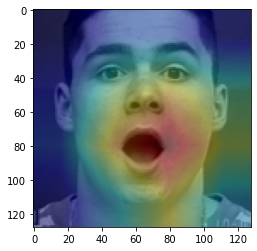

In [23]:
import cv2

CAMs = returnCAM(features_blobs[-1], weight_softmax, [label])

print(CAMs[0].shape)

height, width = 128, 128

heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)

# print(heatmap)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

image = choose
image = np.expand_dims(image, axis=2)
image = np.concatenate((image, image, image), axis=-1)


result = heatmap * 0.3 + image * 0.5
result = result.astype(np.uint8)
# result = image * 0.9
plt.imshow(result)
# cv2.namedWindow('1', cv2.WINDOW_AUTOSIZE)
# cv2.imshow('1', result)
# k = cv2.waitKey(0)
# cv2.destroyAllWindows()

In [167]:
print(logit)
print(label)

tensor([[-5.2771, -3.3193, -3.9023, 12.0429, -1.5271,  0.6622]],
       grad_fn=<AddmmBackward>)
3


In [163]:
print(len(features_blobs))

11
